Epoch 1, ELBO Loss: 172.1651, KL Divergence: 4.2359
Epoch 2, ELBO Loss: 151.7665, KL Divergence: 5.4970
Epoch 3, ELBO Loss: 146.2280, KL Divergence: 5.8545
Epoch 4, ELBO Loss: 143.0556, KL Divergence: 6.0686
Epoch 5, ELBO Loss: 141.0302, KL Divergence: 6.1909
Epoch 6, ELBO Loss: 139.5969, KL Divergence: 6.2913
Epoch 7, ELBO Loss: 138.3818, KL Divergence: 6.3712
Epoch 8, ELBO Loss: 137.4640, KL Divergence: 6.4241
Epoch 9, ELBO Loss: 136.7377, KL Divergence: 6.4665
Epoch 10, ELBO Loss: 136.1127, KL Divergence: 6.5259
Epoch 11, ELBO Loss: 135.5260, KL Divergence: 6.5600
Epoch 12, ELBO Loss: 135.2370, KL Divergence: 6.5984
Epoch 13, ELBO Loss: 134.6946, KL Divergence: 6.6401
Epoch 14, ELBO Loss: 134.3430, KL Divergence: 6.6798
Epoch 15, ELBO Loss: 133.9100, KL Divergence: 6.7130
Epoch 16, ELBO Loss: 133.5490, KL Divergence: 6.7292
Epoch 17, ELBO Loss: 133.2811, KL Divergence: 6.7573
Epoch 18, ELBO Loss: 132.9697, KL Divergence: 6.7822
Epoch 19, ELBO Loss: 132.7298, KL Divergence: 6.8005
Ep

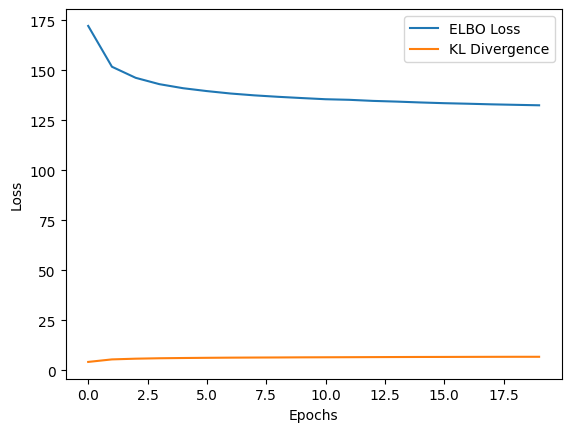

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from layers import VAE


# Loss function
def vae_loss(reconstructed_x, x, mu, log_var):
    recon_loss = nn.BCELoss(reduction="sum")(reconstructed_x, x.view(-1, 28*28))
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_div, recon_loss, kl_div

transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(datasets.MNIST(root='data', train=True, transform=transform, download=True), batch_size=64, shuffle=True)

latent_dim = 2
model = VAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
losses, kl_divs = [], []

for epoch in range(epochs):
    model.train()
    epoch_loss, epoch_kl = 0, 0
    for batch, _ in train_loader:
        optimizer.zero_grad()
        reconstructed, mu, log_var = model(batch)
        loss, recon_loss, kl_div = vae_loss(reconstructed, batch, mu, log_var)
        loss.backward()
        optimizer.step()

        epoch_loss += recon_loss.item()
        epoch_kl += kl_div.item()

    losses.append(epoch_loss / len(train_loader.dataset))
    kl_divs.append(epoch_kl / len(train_loader.dataset))
    print(f"Epoch {epoch+1}, ELBO Loss: {losses[-1]:.4f}, KL Divergence: {kl_divs[-1]:.4f}")

plt.plot(losses, label="ELBO Loss")
plt.plot(kl_divs, label="KL Divergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


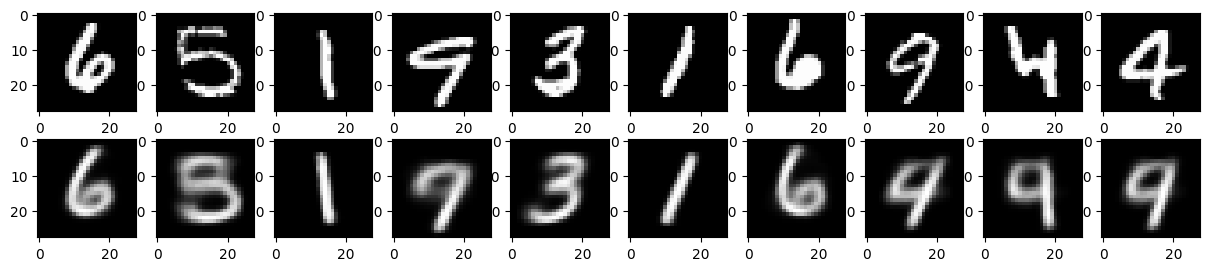

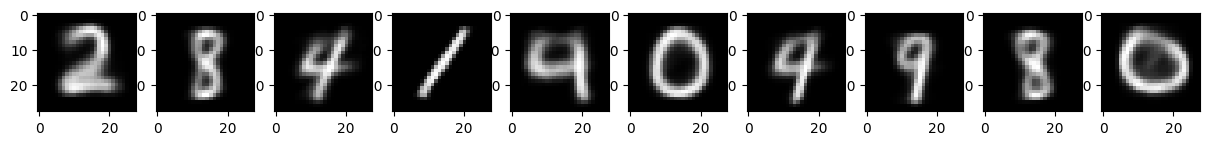

In [2]:
# Visualize reconstruction on test samples
test_loader = DataLoader(datasets.MNIST(root='data', train=False, transform=transform), batch_size=10, shuffle=True)
model.eval()
with torch.no_grad():
    batch, _ =next(iter(test_loader))
    reconstructed, _, _ = model(batch)
    fig, axs = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axs[0, i].imshow(batch[i].view(28, 28), cmap='gray')
        axs[1, i].imshow(reconstructed[i].view(28, 28), cmap='gray')
    plt.show()
    
# Generate new images by sampling from the latent space
with torch.no_grad():
    z = torch.randn(10, latent_dim)
    generated_images = model.decode(z)
    fig, axs = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axs[i].imshow(generated_images[i].view(28, 28), cmap='gray')
    plt.show()


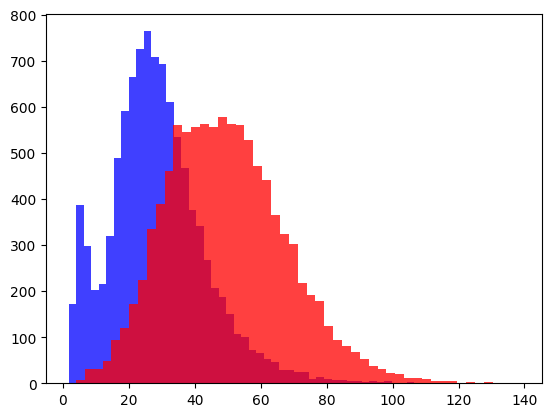

In [9]:
# Compute reconstruction errors for anomaly detection
model.eval()
recon_errors, recon_errors_noise = [], []

# Anomaly detection on noisy test data
with torch.no_grad():
    for batch, _ in test_loader:
        noisy_batch = batch + 0.8 * torch.randn_like(batch)  # Add noise
        
        reconstructed, _, _ = model(batch)
        recon_error = nn.MSELoss(reduction="none")(reconstructed, batch.view(-1, 28*28))
        recon_error = recon_error.sum(dim=1)
        recon_errors.extend(recon_error.cpu().numpy())

        
        reconstructed_noise, _, _ = model(noisy_batch)
        recon_error_noise = nn.MSELoss(reduction="none")(reconstructed_noise, batch.view(-1, 28*28))
        recon_error_noise = recon_error_noise.sum(dim=1)
        recon_errors_noise.extend(recon_error_noise.cpu().numpy())

# Plot distribution of reconstruction errors
plt.hist(recon_errors, bins=50, alpha=0.75, color='blue')
plt.hist(recon_errors_noise, bins=50, alpha=0.75, color='red')
plt.show()


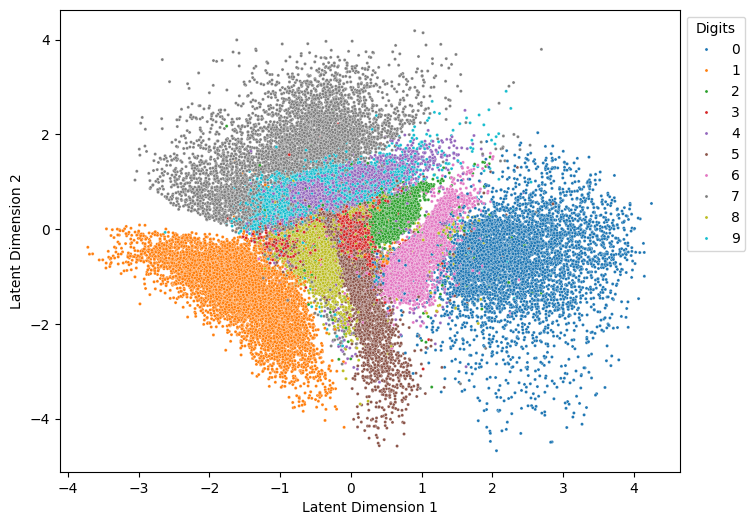

In [7]:
# Visualize latent space using a 2D scatter plot
latent_vectors = []
labels = []

with torch.no_grad():
    for batch, targets in train_loader:
        _, mu, _ = model(batch)
        latent_vectors.extend(mu.cpu().numpy())
        labels.extend(targets.cpu().numpy())

latent_vectors = np.array(latent_vectors)
labels = np.array(labels)

# Scatter plot of latent vectors colored by digit labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_vectors[:, 0], y=latent_vectors[:, 1], hue=labels, palette="tab10", s=5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend(title="Digits", bbox_to_anchor=(1, 1))
plt.show()
